# Personalized Treatment Plans

In [1]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

In [2]:
# Load the dataset
csv_file = 'dataset.csv'
df_csv = pd.read_csv(csv_file)

# Inspect the dataset
print("\n--- Initial Dataset Overview ---")
print(df_csv.info())
print(df_csv.describe())
print(df_csv.head())

# Check and handle missing values
print("\n--- Missing Values ---")
print(df_csv.isnull().sum())


--- Initial Dataset Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 3000 non-null   object
 1   AGE                    3000 non-null   int64 
 2   SMOKING                3000 non-null   int64 
 3   YELLOW_FINGERS         3000 non-null   int64 
 4   ANXIETY                3000 non-null   int64 
 5   PEER_PRESSURE          3000 non-null   int64 
 6   CHRONIC_DISEASE        3000 non-null   int64 
 7   FATIGUE                3000 non-null   int64 
 8   ALLERGY                3000 non-null   int64 
 9   WHEEZING               3000 non-null   int64 
 10  ALCOHOL_CONSUMING      3000 non-null   int64 
 11  COUGHING               3000 non-null   int64 
 12  SHORTNESS_OF_BREATH    3000 non-null   int64 
 13  SWALLOWING_DIFFICULTY  3000 non-null   int64 
 14  CHEST_PAIN             3000 non-null  

In [3]:
numeric_cols = df_csv.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_csv.select_dtypes(include=['object']).columns

# Fill missing values
for col in numeric_cols:
    df_csv[col].fillna(df_csv[col].median(), inplace=True)
for col in categorical_cols:
    df_csv[col].fillna(df_csv[col].mode()[0], inplace=True)

print("\n--- Missing Values After Handling ---")
print(df_csv.isnull().sum())


--- Missing Values After Handling ---
GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC_DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL_CONSUMING        0
COUGHING                 0
SHORTNESS_OF_BREATH      0
SWALLOWING_DIFFICULTY    0
CHEST_PAIN               0
LUNG_CANCER              0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_3912\2403654420.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_csv[col].fillna(df_csv[col].median(), inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_3912\2403654420.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

In [4]:
# Feature Engineering
df_csv['SYMPTOM_SCORE'] = df_csv[['FATIGUE', 'WHEEZING', 'COUGHING']].sum(axis=1)
df_csv['AGE_CHRONIC'] = df_csv['AGE'] * df_csv['CHRONIC_DISEASE']

# Normalize numeric features
scaler = MinMaxScaler()
df_csv[numeric_cols] = scaler.fit_transform(df_csv[numeric_cols])

# Encode categorical variables
encoder = LabelEncoder()
for col in categorical_cols:
    df_csv[col] = encoder.fit_transform(df_csv[col])

print("\n--- Data After Feature Engineering ---")
print(df_csv.head())
print("\n--- Summary Statistics After Feature Engineering ---")
print(df_csv.describe())


--- Data After Feature Engineering ---
   GENDER   AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0       1  0.70      0.0             0.0      0.0            1.0   
1       0  0.50      0.0             1.0      1.0            0.0   
2       0  0.96      1.0             1.0      0.0            0.0   
3       1  0.60      1.0             0.0      0.0            0.0   
4       0  1.00      0.0             0.0      1.0            0.0   

   CHRONIC_DISEASE  FATIGUE  ALLERGY  WHEEZING  ALCOHOL_CONSUMING  COUGHING  \
0              1.0      0.0      1.0       1.0                1.0       1.0   
1              0.0      1.0      1.0       1.0                0.0       0.0   
2              0.0      1.0      0.0       1.0                0.0       0.0   
3              1.0      0.0      1.0       0.0                0.0       1.0   
4              0.0      1.0      0.0       1.0                0.0       0.0   

   SHORTNESS_OF_BREATH  SWALLOWING_DIFFICULTY  CHEST_PAIN  LUNG_CANCER  \
0 

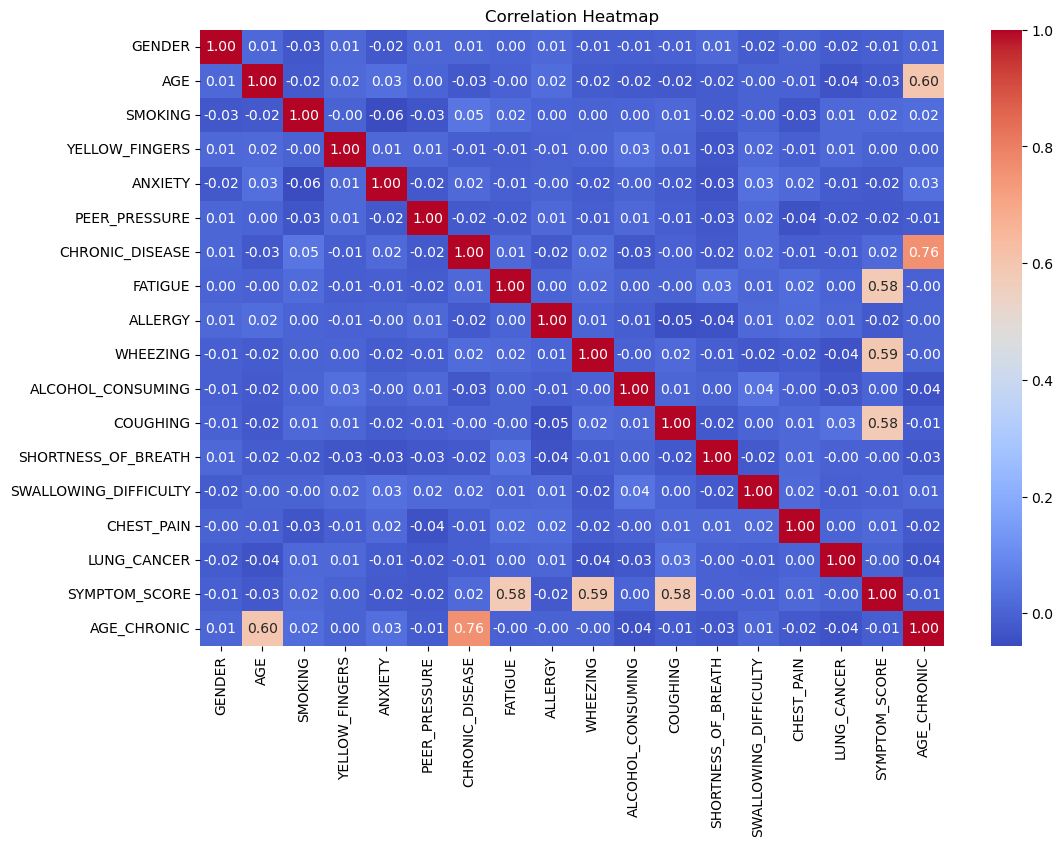

In [5]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_csv.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
# Define features and target
X = df_csv.drop(columns=['LUNG_CANCER'])
y = df_csv['LUNG_CANCER']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("\n--- Class Distribution After SMOTE ---")
print(y_smote.value_counts())


--- Class Distribution After SMOTE ---
LUNG_CANCER
0    1518
1    1518
Name: count, dtype: int64


In [7]:
# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_smote)
print("\n--- Explained Variance Ratio After PCA ---")
print(pca.explained_variance_ratio_)
print("Number of Components:", pca.n_components_)


--- Explained Variance Ratio After PCA ---
[0.99673024]
Number of Components: 1


In [8]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_smote, test_size=0.2, random_state=42, stratify=y_smote)
print("\n--- Train-Test Split Sizes ---")
print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


--- Train-Test Split Sizes ---
Training set: (2428, 1) (2428,)
Test set: (608, 1) (608,)


In [9]:
# Train and Evaluate Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("\n--- Logistic Regression Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1]))

# Hyperparameter Tuning for Logistic Regression
param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)

print("\n--- Logistic Regression Best Parameters ---")
print(grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)


--- Logistic Regression Evaluation ---
Accuracy: 0.5361842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.41      0.47       304
           1       0.53      0.66      0.59       304

    accuracy                           0.54       608
   macro avg       0.54      0.54      0.53       608
weighted avg       0.54      0.54      0.53       608

ROC-AUC: 0.5196827389196677

--- Logistic Regression Best Parameters ---
{'C': 0.1, 'solver': 'liblinear'}
Best ROC-AUC Score: 0.5159539164070069


In [10]:
# Train and Evaluate Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n--- Random Forest Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Hyperparameter Tuning for Random Forest
param_dist = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'max_features': ['sqrt', 'log2'], 'class_weight': ['balanced', None]}
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, n_iter=20, scoring='f1', cv=5)
random_search.fit(X_train, y_train)

print("\n--- Random Forest Best Parameters ---")
print(random_search.best_params_)


--- Random Forest Evaluation ---
Accuracy: 0.4967105263157895
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50       304
           1       0.50      0.50      0.50       304

    accuracy                           0.50       608
   macro avg       0.50      0.50      0.50       608
weighted avg       0.50      0.50      0.50       608


--- Random Forest Best Parameters ---
{'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None}


In [12]:
# Content-Based Recommendation System
# Normalize patient features
scaler = StandardScaler()
patient_features = scaler.fit_transform(df_csv[['AGE', 'SYMPTOM_SCORE', 'CHRONIC_DISEASE']])

# Normalize treatment features and add a dummy feature to match dimensions
treatments = pd.DataFrame({
    'treatment_id': [101, 102, 103],
    'effectiveness_score': [4.5, 4.8, 4.0],
    'side_effects_score': [2.0, 3.0, 1.5]
})
treatments['dummy_feature'] = 0  # Add a dummy feature
treatment_features = scaler.fit_transform(treatments[['effectiveness_score', 'side_effects_score', 'dummy_feature']])

# Compute similarity between patients and treatments
similarity_matrix = cosine_similarity(patient_features, treatment_features)

# Convert similarity matrix to a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=df_csv.index, columns=treatments['treatment_id'])
print("\n--- Patient-Treatment Similarity ---")
print(similarity_df)

# Recommend Treatments
def recommend_treatments(similarity_df, top_n=2):
    recommendations = {}
    for idx in similarity_df.index:
        top_treatments = similarity_df.loc[idx].sort_values(ascending=False).head(top_n).index.tolist()
        recommendations[idx] = top_treatments
    return recommendations

recommendations = recommend_treatments(similarity_df)
print("\n--- Recommended Treatments ---")
print(recommendations)


--- Patient-Treatment Similarity ---
treatment_id       101       102       103
0            -0.042140  0.658913 -0.667933
1            -0.397494  0.371161 -0.302293
2             0.245495  0.737720 -0.805726
3             0.552201 -0.192950  0.088779
4             0.272238  0.740474 -0.813843
...                ...       ...       ...
2995          0.705442  0.159940 -0.303728
2996          0.198426  0.730208 -0.788703
2997         -0.145340  0.601407 -0.588494
2998         -0.725371 -0.317286  0.469162
2999         -0.107471 -0.704059  0.743869

[3000 rows x 3 columns]

--- Recommended Treatments ---
{0: [102, 101], 1: [102, 103], 2: [102, 101], 3: [101, 103], 4: [102, 101], 5: [102, 101], 6: [102, 101], 7: [101, 103], 8: [101, 103], 9: [101, 102], 10: [103, 102], 11: [101, 103], 12: [102, 101], 13: [102, 101], 14: [102, 101], 15: [102, 103], 16: [102, 101], 17: [101, 103], 18: [101, 102], 19: [101, 103], 20: [101, 102], 21: [102, 101], 22: [103, 101], 23: [103, 102], 24: [102, 103]

In [14]:
# Feature Engineering for Prediction

# Ensure patients DataFrame is defined
patients = pd.DataFrame({
    'patient_id': [1, 2, 3, 4],
    'AGE': [25, 40, 35, 60],
    'SYMPTOM_SCORE': [5, 8, 6, 9],
    'CHRONIC_DISEASE': [1, 0, 1, 1]
})

# Ensure treatments DataFrame is defined
treatments = pd.DataFrame({
    'treatment_id': [101, 102, 103],
    'effectiveness_score': [4.5, 4.8, 4.0],
    'side_effects_score': [2.0, 3.0, 1.5]
})

# Create a patient-treatment interaction dataset (Cartesian product)
interaction_data = patients.merge(treatments, how='cross')

# Add similarity scores from similarity_df
interaction_data['similarity_score'] = interaction_data.apply(
    lambda row: similarity_df.loc[row['patient_id'], row['treatment_id']], axis=1
)

# Add derived features
interaction_data['adjusted_effectiveness'] = (
    interaction_data['effectiveness_score'] * interaction_data['similarity_score']
)

print("\n--- Interaction Data After Feature Engineering ---")
print(interaction_data.head())


--- Interaction Data After Feature Engineering ---
   patient_id  AGE  SYMPTOM_SCORE  CHRONIC_DISEASE  treatment_id  \
0           1   25              5                1           101   
1           1   25              5                1           102   
2           1   25              5                1           103   
3           2   40              8                0           101   
4           2   40              8                0           102   

   effectiveness_score  side_effects_score  similarity_score  \
0                  4.5                 2.0         -0.397494   
1                  4.8                 3.0          0.371161   
2                  4.0                 1.5         -0.302293   
3                  4.5                 2.0          0.245495   
4                  4.8                 3.0          0.737720   

   adjusted_effectiveness  
0               -1.788725  
1                1.781573  
2               -1.209173  
3                1.104726  
4             

In [16]:
# Labeling for Supervised Learning

# Redefine the interactions dataset (example)
interactions = pd.DataFrame({
    'patient_id': [1, 1, 2, 3, 4],
    'treatment_id': [101, 102, 101, 103, 102],
    'success': [1, 0, 1, 0, 1]  # 1: Successful treatment, 0: Unsuccessful
})

# Join interaction data with actual outcomes
labeled_data = interaction_data.merge(interactions, on=['patient_id', 'treatment_id'], how='left')

# Handle missing success labels
labeled_data['success'] = labeled_data['success'].fillna(0).astype(int)

# Inspect the resulting dataset
print("\n--- Labeled Data Overview ---")
print(labeled_data.head())
print("\n--- Labeled Data Summary ---")
print(labeled_data['success'].value_counts())


--- Labeled Data Overview ---
   patient_id  AGE  SYMPTOM_SCORE  CHRONIC_DISEASE  treatment_id  \
0           1   25              5                1           101   
1           1   25              5                1           102   
2           1   25              5                1           103   
3           2   40              8                0           101   
4           2   40              8                0           102   

   effectiveness_score  side_effects_score  similarity_score  \
0                  4.5                 2.0         -0.397494   
1                  4.8                 3.0          0.371161   
2                  4.0                 1.5         -0.302293   
3                  4.5                 2.0          0.245495   
4                  4.8                 3.0          0.737720   

   adjusted_effectiveness  success  
0               -1.788725        1  
1                1.781573        0  
2               -1.209173        0  
3                1.104726  

In [17]:
# Train-Test Split

# Train-Test Split
X = labeled_data.drop(columns=['success', 'patient_id', 'treatment_id'])
y = labeled_data['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inspect the training and test set distributions
print("\n--- Class Distribution in Training Set ---")
print(y_train.value_counts(normalize=True))

print("\n--- Class Distribution in Test Set ---")
print(y_test.value_counts(normalize=True))


--- Class Distribution in Training Set ---
success
0    0.777778
1    0.222222
Name: proportion, dtype: float64

--- Class Distribution in Test Set ---
success
0    0.666667
1    0.333333
Name: proportion, dtype: float64


In [21]:
# Model Selection

# Train an XGBoost model
xgb_model = XGBClassifier(random_state=42, n_estimators=100, max_depth=6)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

ROC-AUC: 0.5


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Hyperparameter Tuning

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model to training data
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC Score:", grid_search.best_score_)

# Refit the best model and evaluate on the test set
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n--- Test Set Evaluation ---")
print("Classification Report:\n", classification_report(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\milto\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\milto\anaconda3\Lib\site-packages\skle

Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100}
Best ROC-AUC Score: nan

--- Test Set Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

ROC-AUC: 0.5


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\milto\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\milto\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [23]:
# Recommendation Generation

# Predict probabilities for test data
test_probabilities = xgb_model.predict_proba(X_test)[:, 1]

# Add predictions and relevant columns to the test data
recommendation_data = X_test.copy()
recommendation_data['predicted_success'] = test_probabilities
recommendation_data['treatment_id'] = labeled_data.loc[recommendation_data.index, 'treatment_id'].values
recommendation_data['patient_id'] = labeled_data.loc[recommendation_data.index, 'patient_id'].values

# Recommend treatments with the highest predicted success for each patient
recommendations = (
    recommendation_data.groupby('patient_id')
    .apply(lambda group: group.nlargest(2, 'predicted_success')['treatment_id'].tolist())
)

print("\n--- Treatment Recommendations ---")
print(recommendations)

# Optional: Convert recommendations to a dictionary
recommendations_dict = recommendations.to_dict()
print("\n--- Recommendations as Dictionary ---")
print(recommendations_dict)


--- Treatment Recommendations ---
patient_id
2    [103]
3    [103]
4    [102]
dtype: object

--- Recommendations as Dictionary ---
{2: [103], 3: [103], 4: [102]}


C:\Users\milto\AppData\Local\Temp\ipykernel_3912\2173561810.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: group.nlargest(2, 'predicted_success')['treatment_id'].tolist())


In [24]:
# Validate Recommendations

def evaluate_recommendations(actual, predicted, k=2):
    """
    Evaluate recommendations using precision@k, recall@k, and NDCG@k.

    Args:
    actual (dict): Dictionary with patient_id as keys and list of actual treatments as values.
    predicted (dict): Dictionary with patient_id as keys and list of recommended treatments as values.
    k (int): Number of top recommendations to evaluate.

    Returns:
    tuple: Mean precision@k, recall@k, and NDCG@k across all patients.
    """
    precision, recall, ndcg = [], [], []

    # Ensure actual and predicted have the same patient_ids
    common_patients = set(actual.keys()).intersection(predicted.keys())

    for patient_id in common_patients:
        actual_treatments = set(actual[patient_id])
        predicted_treatments = predicted.get(patient_id, [])[:k]

        # Precision and Recall
        if len(predicted_treatments) > 0:
            precision.append(len(actual_treatments & set(predicted_treatments)) / len(predicted_treatments))
        else:
            precision.append(0)
        recall.append(len(actual_treatments & set(predicted_treatments)) / len(actual_treatments) if actual_treatments else 0)

        # NDCG
        dcg = sum(1 / np.log2(idx + 2) if t in actual_treatments else 0 for idx, t in enumerate(predicted_treatments))
        idcg = sum(1 / np.log2(idx + 2) for idx in range(min(len(actual_treatments), k)))
        ndcg.append(dcg / idcg if idcg > 0 else 0)

    return np.mean(precision), np.mean(recall), np.mean(ndcg)

# Simulated test data
actual_test_data = {
    2: [101, 103],  # Patient 2's actual successful treatments
    3: [103],       # Patient 3's actual successful treatments
    4: [102]        # Patient 4's actual successful treatments
}

# Evaluate
precision, recall, ndcg = evaluate_recommendations(actual_test_data, recommendations)
print(f"Precision@2: {precision:.4f}, Recall@2: {recall:.4f}, NDCG@2: {ndcg:.4f}")


Precision@2: 1.0000, Recall@2: 0.8333, NDCG@2: 0.8710
